<center>

#     
### NATURAL LANGUAGE PROCESSING
## 2023./2024.
# Word Embeddings
## Data: hrWaC, ParlaSent
#### Nika Hell and Josipa Radak      

<img src="https://drive.google.com/uc?export=view&id=1fpghEm1yu_7Ux8VpvYKNN7-jMT8j9wkm" width="600" height="600">

</center>

<center>

##    

## About data preparation

In this notebook, we will perform data preprocessing, preparing the data for GloVe model. Furthermore, we have 2 different datasets: hrWaC 2.1 and ParlaSent 1.0. hrWaC 2.1 is used for training the model, while ParlaSent is used for testing the model. Within this notebook, both datasets will be explored to see what they contain up to the token level, and both datasets will be prepared for the mentioned model.

</center>


**Content of the notebook**


> Libraries and arguments

> Connecting to Google Drive

> Helper functions

>>Loading and reading data from external file

>>>Text file

>>>Pickle file

>>>JSON file

>>Plotting the data

>>Cleaning the data

>>Tokens and vocabulary

>**hrWaC 2.1**

>>Loading and Extracting Data from XML File

>>Sentences

>>Tokens

>>>Tokenizing sentences

>>>Exploring the tokens

>>>>Removing stopwords

>>Data Preprocessing for Word Embedding Training

>>>GloVe (Global Vectors for Word Representation)

>>>>Vocabulary

>>>>Co-occurrence matrix

>>>>Remove variables

>**ParlaSent 1.0**

>>Loading the data

>>Sentences

>>Tokens

>>>Tokenizing sentences

>>>Exploring the tokens

>>>>Removing stopwords

>>Data Preprocessing for Word Embedding Testing

>>>GloVe (Global Vectors for Word Representation)


## Libraries and arguments

Several powerful libraries in Python facilitate data preparation tasks, providing a wide range of functions and tools for efficient data manipulation, enabling efficient navigation, manipulation, and analysis of data, regardless of its format or complexity. Integrating these tools into the workflow sets the stage for a successful data preparation process in any project.

In [ ]:
import os # module for interacting with the operating system
import numpy as np  # import NumPy for scientific computing
import pandas as pd  # import Pandas for data manipulation and analysis

import matplotlib.pyplot as plt  # import pyplot module for creating visualizations
import seaborn as sns  # import Seaborn for statistical data visualization
from wordcloud import WordCloud  # import WordCloud for creating word clouds

import xml.etree.ElementTree as ET  # import ElementTree for XML data parsing

from collections import Counter, defaultdict  # Import Counter for counting occurrences and defaultdict for handling missing keys

import re  # import re for regular expressions and string manipulation

import pickle  # import pickle for serializing and deserializing Python objects
import json # import the 'json' library to handle JSON data

from argparse import Namespace # the namespace class is used to create an object that holds attributes corresponding to command-line arguments

from nltk import ngrams # imports the ngrams function from the Natural Language Toolkit (NLTK), which is used for generating n-grams
from tqdm import tqdm # imports the tqdm library, which provides a progress bar for loops

import gc # garbage collector

To avoid having arguments in multiple places, we add a Namespace to store all necessary arguments. This is important for better organization and readability of the code, as it allows us to group related arguments together and access them easily throughout the program. Additionally, using a Namespace helps prevent naming conflicts and makes it simpler to pass arguments between different parts of the code.

In [ ]:
args = Namespace(
    ## training file
    training_file= "hrWaC2.1.14.xml",
    sentences = 'sentences.txt',
    cleaned_sentences = 'cleaned_sentences.txt',
    tokens = 'tokens.txt',

    window_size=2,
    seed = 1337,
    co_occurrence_matrix = 'co_occurrence_matrix.pkl',
    glove_vocab = 'glove_vocab.pkl',

    ## testing files
    tokens_test = 'tokens_test.csv',
    test_file_1 = "ParlaSent_BCS.jsonl",
    test_file_2 = "ParlaSent_BCS_test.jsonl",
    cleaned_sentences_test = 'cleaned_sentences_test.txt',

    # glove test
    classificator_train = 'classificator_train.csv',
    classificator_test = 'classificator_test.csv',
    co_occurrence_matrix_test = 'co_occurrence_matrix_test.pkl'
)

## Connecting to Google Drive

In this section, we are connecting to Google Drive in order to store the necessary files on disk as well as retrieve the required files from the disk. Furthermore, to keep everything organized, we have decided to store all outputs resulting from this notebook in a single directory named "preprocessing". Additionally, there is already a file named 'nlp.py' from which we will extract the necessary classes for some necessary steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change the current working directory
%cd /content/drive/MyDrive/nlp_project/

/content/drive/.shortcut-targets-by-id/1dadLNnejsKWL1qhI8AmHtxjCR430s42m/nlp_project


In [ ]:
from nlp import Vocabulary # import helpers from nlp.py script

In [ ]:
%cd /content/drive/MyDrive/nlp_project/preprocessing

/content/drive/.shortcut-targets-by-id/1dadLNnejsKWL1qhI8AmHtxjCR430s42m/nlp_project/preprocessing


## Helper functions

### Loading and reading data from external file
When dealing with extensive datasets or complex tasks, breaking down the workflow into manageable steps is essential. To streamline this process and avoid redundant computations, we've implemented helper functions for saving intermediate results. Acting as checkpoints, these functions enable us to resume work from specific stages without reloading the entire corpus. This approach enhances efficiency, particularly in scenarios involving large datasets or time-consuming operations. The helper functions store critical intermediate data, such as tokenized text or vocabulary, facilitating a more modular and reproducible workflow. These functions collectively provide a set of tools for handling text and data storage, ensuring robustness in the face of potential errors.

#### Text file

In [ ]:
# attempt to open a specified file in write mode
# iterate through each word in the input list and writes it to the file followed by a tab as a separator
# print a success message if the words are successfully saved
# handle exceptions such as file not found or other writing errors, printing detailed error messages
def save_to_txt_file(data, filename='data.txt', separator='\t'):
  # attempt to open the specified file in write ('w') mode
  try:
    with open(filename, 'w') as file:
      # iterate through each element in the 'data' list
      for element in data:
        # write the element to the file followed by a tab ('\t') as a separator
        file.write(str(element) + separator)
    # print a success message indicating that data has been saved to the file
    print(f"Data has been saved to the file: {filename}")
  # handle exceptions, such as file not found or other writing errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error saving data to '{filename}': {e}")

In [ ]:
# attempt to open a specified file in read mode
# read the content of the file into a string
# split the string into a list of tokens using a tab as a separator
# remove any empty strings from the list of tokens
# return the list of tokens
# handle the case where the file is not found or encounters reading errors, printing appropriate error messages
def read_from_txt_file(filename='data.txt', separator='\t'):
  # attempt to open the specified file in read ('r') mode
  try:
    with open(filename, 'r') as file:
      # read the content of the file into a string
      elements_str = file.read()
      # split the string into a list of elements using the specified separator
      elements_list = elements_str.split(separator)
    # remove any empty strings from the list of elements
    elements_list = list(filter(None, elements_list))
    # return the list of elements
    return elements_list
  # handle the case where the file is not found
  except FileNotFoundError:
    # print an error message indicating that the file was not found
    print(f"Error: File '{filename}' not found.")
    # return None to signify the absence of data
    return None
  # handle other exceptions, such as reading errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error reading data from '{filename}': {e}")
    # return None to signify the inability to read the data
    return None

#### Pickle file

In [ ]:
# attempt to open a specified file in binary write mode
# use the pickle module to serialize and save the input vocabulary to the file
# print a success message if the vocabulary is successfully saved
# handle exceptions, such as writing errors, and prints detailed error messages
def save_serialized_object(data, filename='serialized_data.pkl'):
  # attempt to open the specified file in binary write ('wb') mode
  try:
    with open(filename, 'wb') as file:
      # use the pickle module to serialize and save the data to the file
      pickle.dump(data, file)
    # print a success message indicating that the data has been saved to the file
    print(f"Data has been saved to the file: {filename}")
  # handle exceptions, such as writing errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error saving data to '{filename}': {e}")

In [ ]:
# attempt to open a specified file in binary read mode
# use the pickle module to deserialize and load the vocabulary from the file
# return the loaded vocabulary
# handle the case where the file is not found or encounters reading errors, printing appropriate error messages
def load_serialized_object(filename='serialized_data.pkl'):
  # attempt to open the specified file in binary read ('rb') mode
  try:
    with open(filename, 'rb') as file:
      # use the pickle module to deserialize and load the data from the file
      loaded_data = pickle.load(file)
    # return the loaded data
    return loaded_data
  # handle the case where the file is not found
  except FileNotFoundError:
    # print an error message indicating that the file was not found
    print(f"Error: File '{filename}' not found.")
    # return None to signify the absence of data
    return None
  # handle other exceptions, such as reading errors
  except Exception as e:
    # print an error message with details about the encountered exception
    print(f"Error loading data from '{filename}': {e}")
    # return None to signify the inability to load the data
    return None

#### JSON file

In [ ]:
# 'load_jsonl' loads json file and creates 'dataset' that contains a list of
# dictionaries, each representing a JSON object from the file
def load_jsonl(file_path):
  data = [] # initialize an empty list to store the loaded JSON objects
  # open the specified file in read ('r') mode with UTF-8 encoding
  with open(file_path, 'r', encoding='utf-8') as file:
    for line in file: # iterate through each line in the file
      # load each line as a JSON object
      json_obj = json.loads(line)
      # append the loaded JSON object to the 'data' list
      data.append(json_obj)
  # return the list containing all the loaded JSON objects
  return data

### Plotting the data

These functions are designed to assist in visualizing various aspects of text data, offering insights into word frequencies, Zipf's law adherence, and more. Each function serves a specific purpose and enhances the interpretability of the underlying data.


In [ ]:
# plots the distribution of word frequencies in a logarithmic scale
def plot_word_frequency_distribution(freq_dict, color='blue'):
  # x-axis represents words sorted by their frequency
  x = list(range(len(freq_dict)))
  # y-axis represents word frequencies (in log scale)
  y = sorted(freq_dict.values(), reverse=True)
  plt.title('Distribution of Word Frequencies')  # set the title of the plot
  plt.xlabel('V')  # label for the X-axis
  plt.ylabel('Frequencies')  # label for the Y-axis
  plt.yscale('log')  # use a logarithmic scale for the Y-axis
  plt.plot(x, y, color=color)  # plot the word frequencies with the specified color
  plt.show();



**Zipf's Law** states that the frequency of a word is inversely proportional to it's rank. This function generates a plot representing Zipf's Law, where the x-axis corresponds to the logarithm of the rank of each word, and the y-axis corresponds to the logarithm of the word's frequency. The resulting plot helps visualize the distribution of word frequencies in a manner consistent with Zipf's Law.

Empirical law:
* r - rank of the word
* f - frequency of the word

$f \propto \frac{1}{r}$

In [ ]:
# plots Zipf's Law for word frequencies in a logarithmic scale
def plot_zipfs_law(freq_dict, color='blue'):
  # y-axis for frequencies
  y = [f for _, f in freq_dict.most_common()]
  # x-axis for frequencies
  x = list(range(len(freq_dict.most_common())))
  plt.title("Zipf's Law")  # set the title of the plot for Zipf's law
  plt.xlabel('log(r)')  # label for the X-axis
  plt.ylabel('log(f)')  # label for the Y-axis
  plt.yscale('log')  # use a logarithmic scale for the Y-axis
  plt.xscale('log')  # use a logarithmic scale for the X-axis
  plt.plot(x, y, color=color)  # plot the word frequencies following Zipf's law with the specified color
  plt.show();

In [ ]:
# generate_word_cloud function creates a Word Cloud from a Counter frequency dictionary
# it takes three parameters: counter_freq, max_words, and title
def generate_word_cloud(counter_freq, max_words, title):
  # create a WordCloud object with specified parameters
  wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate_from_frequencies(counter_freq)
  # display the WordCloud using matplotlib
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  # set the title for the WordCloud
  plt.title(title)
  # show the WordCloud
  plt.show();

In [ ]:
# plot_word_length_distribution function generates a bar chart to visualize the distribution of word lengths in a given list of pre-tokenized words
# it takes two parameters: words (a list of pre-tokenized words) and title (the title for the generated bar chart)
def plot_word_length_distribution(words, title, max_word_length = 30):
  # calculate the lengths of each pre-tokenized word in the list
  word_lengths = [len(word) for word in words]
  # determine the maximum word length to set the upper limit for the bar chart
  # count the frequency of each word length
  length_counts = {length: word_lengths.count(length) for length in range(1, max_word_length + 1)}
  # create a bar chart using seaborn
  plt.figure(figsize=(10, 6))
  sns.barplot(x=list(length_counts.keys()), y=list(length_counts.values()), color='skyblue')
  # set titles and axis labels for the bar chart
  plt.title(title)
  plt.xlabel('Word Length')
  plt.ylabel('Frequency of Occurrence')
  # show the generated bar chart
  plt.show();

In [ ]:
# calculates the frequency of each stopword in the provided list of words,
# sorts them by frequency in descending order, and creates a bar chart to visualize the occurrence frequency of stopwords
# the resulting chart aids in understanding the distribution of stopwords in the given data
def plot_stopwords_frequency(words, stopwords, title):
  # calculate the frequency of each stopword
  stopwords_frequency = Counter(word for word in words if word.lower() in stopwords)
  # sort stopwords by frequency in descending order
  sorted_stopwords_frequency = dict(sorted(stopwords_frequency.items(), key=lambda item: item[1], reverse=True))
  # create a bar chart for the frequency of stopwords
  plt.figure(figsize=(22, 8))
  plt.bar(sorted_stopwords_frequency.keys(), sorted_stopwords_frequency.values(), color='skyblue')
  # set titles and axis labels
  plt.title(title)
  plt.xlabel('Stopwords')
  plt.ylabel('Frequency of Occurrence')
  # show the chart
  plt.xticks(rotation=90)  # rotate x-axis labels for better readability
  plt.tight_layout()  # improve the layout of graphical elements
  plt.show();

In [ ]:
def visualize_label_counts(dataframe, column_name):
    """
    Visualize the counts of each unique label in a given column of a DataFrame.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the column of interest.
        column_name (str): The name of the column for which label counts are to be visualized.
    """
    label_counts = dataframe[column_name].value_counts()

    # Plotting
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar')
    plt.title('Count of Each Label')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Cleaning the data

Certain data cleaning functions are applied to both datasets. To avoid redundant initialization, we will place them in this section.


In the following code, we perform various text preprocessing operations on textual data. These operations are designed to clean and prepare the text for further analysis or natural language processing tasks. Here's an overview of the operations performed by the provided functions:

- `preprocess_text`: This function performs basic text preprocessing. It first tokenizes the text into words, converts each word to lowercase, and then joins them back into sentences with spaces. Next, it removes hyperlinks, adds spaces around punctuation marks, and eliminates any characters that are not letters, spaces, or diacritic marks such as č, ć, ž, š, đ. Finally, it removes words containing 5 or more consecutive consonants.

- `filter_words(sentences)`: This function filters words in sentences based on specific criteria. It identifies words with two consonants, words longer than 30 characters, and words consisting of only one letter, where that letter is a consonant (excluding 'k'). The identified words are replaced with an empty string.

- `remove_repeated_words(text)`: This function removes words in the text that contain repeated characters. If a word contains the same character three or more times consecutively, only one instance of that character is retained.

- `remove_ha_words(text)`: This function removes words consisting only of the letters 'h' and 'a' and having more than 2 letters. It replaces the identified words with an empty string.

- `remove_nonCroatian_words(text)`: This function removes words containing the letters 'x', 'y', or 'w' from the text, as these letters are not part of the Croatian alphabet. The identified words are replaced with an empty string.

For tokens only:

- Remove Stop Words (`remove_stop_words`):

  - Remove common stop words (e.g., articles, conjunctions) from the text.
  - The list of Croatian stopwords used in this process is sourced from: https://github.com/stopwords-iso/stopwords-hr/blob/master/stopwords-hr.txt.

In [ ]:
def preprocess_text(text):
  # split the text into words, convert each word to lowercase, and join them back into a sentence with spaces
  text = ' '.join(word.lower() for word in text.split(" "))
  # remove links
  text = re.sub(r'http[s]?://\S+', '', text)
  # add spaces around punctuation marks (.,!?)
  text = re.sub(r"([.,!?])", r" \1 ", text)
  # remove characters that are not letters, spaces, or diacritics (ć, č, ž, š, đ)
  text = re.sub(r"[^a-zA-Z\sćčžšđ]+", r"", text)
  # remove words with 5 or more consecutive consonants
  text = re.sub(r'\b[bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ]{5,}\b', r"", text)
  # remove excessive whitespaces
  text = re.sub(r"\s+", " ", text).strip()
  return text # return text

In [ ]:
def filter_words(sentences):
  # define regular expressions for finding words with two consonants,
  # longer than 30 characters, and those words that have only one letter and that letter is a consonant (excluding k)
  regex_2_consonants = r'\b(?![aeiou])[b-df-hj-np-tv-zčćžšđ]{2}\b'
  regex_1_consonants = r'\b(?![aeiouk])[b-df-hj-np-tv-zčćžšđ]{1}\b'
  regex_longer_than_30 = r'\b\w{31,}\b'  # words longer than 30 characters

  # finding words in each sentence and replacing the found words with an empty string
  for i, sentence in enumerate(sentences):
    # replace words with an empty string
    sentences[i] = re.sub(regex_2_consonants, '', sentences[i])
    sentences[i] = re.sub(regex_1_consonants, '', sentences[i])
    sentences[i] = re.sub(regex_longer_than_30, '', sentences[i])
    sentences[i] = re.sub(r"\s+", " ", sentences[i]).strip() # remove excessive whitespaces

  return sentences

In [ ]:
# removes repeated characters from the input text
def remove_repeated_words(text):
  return re.sub(r'([a-zA-Z\šćčžšđ])\1\1+', r'\1', text)

In [ ]:
def remove_ha_words(text):
  # define a regular expression to find words consisting of only "h" and "a" letters and having more than 2 letters
  regex_ha_words = r'\b[ha]{3,}\b'
  # find all words matching the pattern in the text
  replaced_text = re.sub(regex_ha_words, r'',text)
  # remove extra spaces
  replaced_text = re.sub(r"\s+", " ", replaced_text).strip()
  return replaced_text

In [ ]:
def remove_nonCroatian_words(text): # Croatian language doesen't have words with letters x, y, w because they are not in croatian alphabet
  pattern = r'\b\w*[xXyYwW]\w*\b' # define a pattern to find non-Croatian words
  text = re.sub(pattern, '', text) # remove non-Croatian words from the text
  text = re.sub(r"\s+", " ", text).strip() # remove extra spaces
  return text

Stopwords are common words in a language that are often filtered out during natural language processing tasks because they typically do not carry significant meaning. These words, such as "the," "is," "and," "or," etc., occur frequently in texts but contribute little to the overall semantics of the content. Removing stopwords helps to reduce noise and focus on the essential content of the text during analysis or model training.

In [ ]:
stopwords_hr = set([
    'a','ako','ali','bi','bih','bila','bili','bilo','bio','bismo','biste',
    'biti','bumo','da','do','duž','ga','hoće', 'hoćemo','hoćete','hoćeš',
    'hoću','i','iako','ih','ili','iz','ja','je','jedna','jedne','jedno',
    'jer','jesam','jesi','jesmo','jest','jeste','jesu','jim','joj','još',
    'ju','kada','kako','kao','koja','koje','koji','kojima','koju','kroz',
    'li','me','mene','meni','mi','mimo','moj','moja','moje','mu','na','nad',
    'nakon','nam','nama','nas','naš','naša','naše','našeg','ne','nego',
    'neka','neki','nekog','neku','nema','netko','neće','nećemo','nećete'
    ,'nećeš','neću','nešto','ni','nije','nikoga','nikoje','nikoju','nisam',
    'nisi','nismo','niste','nisu','njega','njegov','njegova','njegovo','njemu',
    'njezin','njezina','njezino','njih','njihov','njihova','njihovo','njim',
    'njima','njoj','nju','no','o','od','odmah','on','ona','oni','ono','ova',
    'pa','pak','po','pod','pored','prije','s','sa','sam','samo','se','sebe',
    'sebi','si','smo','ste','su','sve','svi','svog','svoj','svoja','svoje',
    'svom','ta','tada','taj','tako','te','tebe','tebi','ti','to','toj','tome',
    'tu','tvoj','tvoja','tvoje','u','uz','vam','vama','vas','vaš','vaša','vaše',
    'već','vi','vrlo','za','zar','će','ćemo','ćete','ćeš','ću','što'
    ])# croatian stopwords

In [ ]:
def remove_stop_words(sentences, stop_words):
  # initialize an empty list to store the cleaned sentences
  cleaned_sentences = []
  # iterate through each sentence in the input list of sentences
  for sentence in sentences:
    # split the sentence into words
    words = sentence.split()
    # create a new sentence by joining only those words that are not in the stop words list
    cleaned_sentence = ' '.join([word for word in words if word.lower() not in stop_words])
    # add the cleaned sentence to the list of cleaned sentences
    cleaned_sentences.append(cleaned_sentence)
  # return the list of cleaned sentences
  return cleaned_sentences

In [ ]:
def simple_preprocess_text(text):
  # split the text into words, convert each word to lowercase, and join them back into a sentence with spaces
  text = ' '.join(word.lower() for word in text.split(" "))
  # remove links
  text = re.sub(r'http[s]?://\S+', '', text)
  # add spaces around punctuation marks (.,!?)
  text = re.sub(r"([.,!?])", r" \1 ", text)
  # remove characters that are not letters, spaces, or diacritics (ć, č, ž, š, đ)
  text = re.sub(r"[^a-zA-Z\sćčžšđ]+", r"", text)
  # remove excessive whitespaces
  text = re.sub(r"\s+", " ", text).strip()
  return text # return text

### Tokens and vocabulary

The following two functions, `tokenize_sentences` and `create_vocabulary`, are essential preprocessing steps in natural language processing (NLP) tasks. These functions operate on a list of sentences to facilitate further analysis or modeling.
The first function, `tokenize_sentences`, splits each sentence into individual tokens using whitespace as a delimiter. It then flattens the list of token subsets and removes any leading or trailing whitespace from each token. The resulting list of tokens is returned. The second function, `create_vocabulary`, takes a list of tokens as input and creates a vocabulary. It removes duplicate tokens by converting them into a set. Then, it assigns a unique index to each token in the vocabulary and stores the result in a dictionary where the token serves as the key and the index as the value. Finally, it returns the vocabulary dictionary.

In [ ]:
def tokenize_sentences(sentences):
  # create token subsets by splitting each cleaned sentence into individual tokens using a space as the delimiter
  token_subsets = [tokens.split(' ') for tokens in sentences]
  # flatten the list of token subsets and strip each token
  tokens = [token.strip() for sublist in token_subsets for token in sublist]
  return tokens

In [ ]:
# create simple vocabulary
def create_vocabulary(tokens):
  vocab = set(tokens) # create set of words (so they dont repeat)
  vocab_dict = {word: idx for idx, word in enumerate(vocab)} # create dict
  return vocab_dict # return vocabulary

## **hrWaC 2.1**

**About the dataset**

The Croatian web corpus, **hrWaC**, serves as a comprehensive collection of textual data gathered by systematically crawling websites within the .hr top-level domain during two distinct periods: in 2011 and subsequently in 2014. This corpus plays a crucial role in linguistic research and natural language processing tasks. To ensure its reliability and utility, the hrWaC corpus underwent meticulous preprocessing steps. Researchers and practitioners leverage the hrWaC corpus to investigate linguistic phenomena, develop language models, and address various challenges in natural language understanding and processing.

**Understanding the structure**

The hrWaC corpus is a comprehensive linguistic resource structured as a large corpus, divided into paragraphs for systematic organization. Each paragraph contains essential metadata, including urldomain, url, language, and langdistr. Within each paragraph, the &lt;s&gt; element encapsulates the linguistic content (one sentence). The content within the &lt;s&gt; element is formatted as follows: each line (separated by \n) represents a word in three forms (separated by \t).

1. Scraped Form: The original form of the word as scraped during the data collection process.

2. Canonical Form: The proper form of the word, considering cases where the scraped version did not include diacritics (if applicable).

3. Lemma: The lemma of the word, representing its base or dictionary form.

The last element in each line denotes the word type, indicating whether it is a verb, noun, or another linguistic category. Each line within a paragraph collectively forms a sentence, and &lt;g/&gt; elements are present to mark components within the sentence, such as who wrote the paragraph and else. This structured approach allows for a nuanced exploration of linguistic phenomena, providing researchers with valuable insights into language usage and patterns.

**Efficient Processing Strategies**

When dealing with the hrWaC corpus, which is a substantial word corpus of around 2.41 gigabytes stored in XML format, it becomes imperative to adopt a systematic approach to ensure efficient handling and analysis. The complexity and size of the corpus necessitate a methodical process to prevent issues like memory overflow, slow processing, or system crashes. By adopting a systematic approach that includes chunked processing, efficient memory management, and iterative analysis, the hrWaC corpus can be effectively handled without overwhelming system resources. This strategy ensures a balance between processing speed and memory consumption, allowing for a seamless exploration of the extensive word corpus.


###  Loading and Extracting Data from XML File

In this section, the focus is on the loading and extraction of data from an XML file, specifically dealing with a linguistic corpus stored in XML format. The primary objective is to systematically process paragraphs, sentences, and corresponding word information. The code employs the ElementTree module to iteratively navigate through the XML file, extracting words and other pertinent details, if necessary.

To optimize memory usage, the code systematically clears processed &lt;p&gt; elements from memory after extraction. Assertions are implemented to validate whether the number of paragraphs and sentences align with expected values.

The extracted sentences are meticulously processed and stored in specific file.

In [ ]:
words = [] # array for saving words in their canonical form
num_p = 0 # number of paragraphs in corpus

In [ ]:
# process <p> element
def process_element(element):
  # loop through all <s> elements inside the current <p> element
  for s_element in element.findall('.//s'):
    # split each line of text in <s> element and extract the word in it's canonical form from each line
    words_per_line = [line.split('\t')[1] for line in s_element.text.strip().split('\n') if line.strip()]
    # append the words to their respective array
    words.append(words_per_line)

In [ ]:
# iterate through events (start and end) and elements in the XML file using the ElementTree iterator
for event, element in ET.iterparse(args.training_file, events=('start', 'end')):
  # check if the event is the start of an element and the element is a <p> element
  if event == 'start' and element.tag == 'p':
    num_p += 1 # increment number of paragraphs
    # processing the beginning of the <p> element (no action specified here) - pass
    pass
  # check if the event is the end of an element and the element is a <p> element
  elif event == 'end' and element.tag == 'p':
    # process the end of the <p> element by calling the process_element function
    process_element(element)
    # clear the element from memory after processing to free up resources
    element.clear()

# clean up the remaining memory by creating a new XML tree and writing it to a temporary file
ET.ElementTree(ET.Element("corpus")).write('temp.xml')

In [ ]:
print(f"The number of paragraphs in the corpus is: {num_p}.")
print(f"The number of sentences in the corpus is: {len(words)}.")
i = 1002
print(f"The {i}-th example of a sentence:\n{words[i]}.")

In [ ]:
# check if numbers are matching
assert num_p == 1982756
assert len(words) == 4600894

In [ ]:
# convert lists of lists to space-separated or comma-separated strings - sentences
sentences = [' '.join(sentence) for sentence in words]

In [ ]:
# show the first 3 sentences
sentences[:3]

In [ ]:
# save a series of sentences in a .txt file where each sentence is in a separate line
save_to_txt_file(sentences, filename=args.sentences, separator='\n')
del sentences, i, num_p, words
gc.collect()

### Sentences



The following code snippet represents a comprehensive preprocessing pipeline for text data. It consists of various steps aimed at cleaning and filtering sentences extracted from a text source. This preprocessing is crucial for improving the quality of the data and preparing it for downstream natural language processing (NLP) tasks.

The sentence cleaning methods were applied for several reasons. Initially, some standard practices commonly used in sentence cleaning were followed. Then, during the inspection of sentences, certain issues were identified. For instance, some sentences consisted of only one word, and since we need context for training, such sentences would not provide that context and were therefore removed. Additionally, some modifications were made after inspecting the tokens themselves (specific inspection is demonstrated in the section below).

In [ ]:
# check if the variable sentences exists in the local or global scope
if 'sentences' in locals() or 'sentences' in globals():
  if sentences == None: # if variable sentences exists, but its empty
    sentences = read_from_txt_file(args.sentences, separator='\n')  # load sentences from text file
  else:
    # if sentences is already defined, do nothing (pass)
    pass
else:
  # if sentences is not defined, attempt to load data from 'sentences.txt'
  sentences = read_from_txt_file(args.sentences, separator='\n')

In [ ]:
# check if the whole file is read
assert len(sentences) == 4600894

In [ ]:
# display the first n sentences before cleaning
n = 10
print(f"Show first {n} sentences:")
sentences[:n]

In [ ]:
# all to lowercase, remove punctuation, only letters, remove words that are longer than 5 characters and all characters are consonants
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
# remove words with more than 30 letters, words with 2 consonant characters and words of only one consonant character (excluding k)
cleaned_sentences = filter_words(cleaned_sentences)
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
# repeated letter (example: 'daaaaa' -> 'da', but not koordinata)
cleaned_sentences = [remove_repeated_words(sentence) for sentence in cleaned_sentences]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
# remove laughing words (example: 'hahahahhaha' -> '')
cleaned_sentences = [remove_ha_words(sentence) for sentence in cleaned_sentences]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
# remove all words that have x, y and w - it was noticed that there are a lot of non-Croatian words
cleaned_sentences = [remove_nonCroatian_words(sentence) for sentence in cleaned_sentences]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
# remove all sentences that have less then two words
cleaned_sentences = [sentence for sentence in cleaned_sentences if len(sentence.split()) >= 2]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

In [ ]:
cleaned_sentences = list(set(cleaned_sentences)) # remove duplicated sentences
# display the first n sentences before cleaning
n = 10
print(f'Number of sentences is:{len(cleaned_sentences)}')
print(f"Show first {n} sentences:")
cleaned_sentences[:n]

In [ ]:
# save the cleaned sentences to a .txt file
save_to_txt_file(cleaned_sentences, args.cleaned_sentences, separator='\n')
# delete variables after cleaning and saving, indicating that it is no longer needed to free up memory
del sentences, cleaned_sentences, n
gc.collect()

### Tokens

Tokens are fundamental units of text derived from the process of tokenization. Tokenization is the procedure of breaking down a text into smaller units, known as tokens, for easier analysis or processing. Tokens can represent individual words, numbers, punctuation marks, or other linguistic units, depending on the specifics of the applied tokenization. This process is often crucial in natural language processing (NLP) and text analysis.

While sentences will be essential for training our model, it is equally important to explore the individual tokens within the dataset. This exploration includes analyzing the frequency distribution of words, identifying the most common tokens, and understanding the patterns that emerge from token-level analysis. By delving into the token-level characteristics, we can gain insights into the underlying structure and linguistic nuances of the text data, enriching our understanding beyond sentence boundaries. This comprehensive exploration lays the foundation for effective natural language processing and facilitates better-informed decisions in model training.


#### Tokenizing sentences

The obtained sentences are tokenized by splitting them into individual tokens based on spaces. Initially, we obtain a list of lists of tokens, which is not convenient for further analysis. To address this, we further flatten the list. Ultimately, these tokens are stored in a file for subsequent processing.

In [ ]:
# check if the variable sentences exists in the local or global scope
if 'sentences' in locals() or 'sentences' in globals():
  if sentences == None: # if variable sentences exists, but its empty
    sentences = read_from_txt_file(args.sentences, separator='\n')  # load sentences from text file
  else:
    # if sentences is already defined, do nothing (pass)
    pass
else:
  # if sentences is not defined, attempt to load data from 'sentences.txt'
  sentences = read_from_txt_file(args.sentences, separator='\n')

In [ ]:
# convert the text to lowercase, add spaces around punctuation marks, remove characters that are not letters or spaces
sentences = [simple_preprocess_text(sentence) for sentence in sentences] # convert the text to lowercase.

In [ ]:
tokens = tokenize_sentences(sentences) # split sentences into tokens

In [ ]:
# save tokens to the .txt file
save_to_txt_file(tokens, args.tokens, separator='\t')
# delete variables after processing, indicating that they are no longer needed
del tokens, sentences
gc.collect()

#### Exploring the tokens

In [ ]:
# check if the variable tokens exists in the local or global scope
if 'tokens' in locals() or 'tokens' in globals():
  if tokens == None: # if variable tokens exists, but its empty
    tokens = read_from_txt_file(args.tokens, separator='\t')  # load tokens from text file
  else:
    # if tokens is already defined, do nothing (pass)
    pass
else:
  # if tokens is not defined, attempt to load data from 'tokens.txt'
  tokens = read_from_txt_file(args.tokens, separator='\t')

In [ ]:
freq = Counter(tokens) # count the frequency of each token

In [ ]:
freq.most_common(20) # display the 20 most common words and their frequencies

In [ ]:
plot_word_frequency_distribution(freq)

In this plot, we observe a distinctive long-tail pattern where a select few words, typically common ones, exhibit high frequencies, creating a steep slope on the left side. Progressing towards the right, the frequency of words diminishes, forming a more gradual slope. This distribution aligns with the characteristic patterns found in natural language, commonly associated with Zipf's law. The sharp decline in frequency underscores that a small set of words significantly contributes to the overall word count, while the majority of words occur infrequently.

In [ ]:
plot_zipfs_law(freq)

The preceding graph illustrates Zipf's Law, depicting a distribution similar to the previous plot but with a slight reorganization of data. In this version, the logarithm of ranks and the logarithm of frequencies are plotted. Notably, the curve descends almost linearly as we progress towards higher logarithmic frequencies (logarithm of ranks). This linear descent suggests a consistent pattern in the relationship between the logarithm of ranks and the logarithm of frequencies. This result reinforces Zipf's Law principles, highlighting that a small number of elements (tokens in this case) have high frequencies, while the majority exhibit lower frequencies. The nearly linear decline in the log-log plot signifies the characteristic inverse relationship between the rank and frequency of elements, underscoring the hierarchical distribution inherent in Zipf's Law. The graph visually confirms the anticipated pattern in the distribution of token frequencies, aligning with the predictions of Zipf's Law.

In [ ]:
# set the maximum number of words to be displayed in the WordCloud
max_words_to_display = 50 # adjust as needed
# title for the WordCloud
wordcloud_title = "Word Cloud of cleaned tokens"
# generate and display the WordCloud
generate_word_cloud(freq, max_words_to_display, wordcloud_title)

In [ ]:
# title for the histogram
histogram_title = "Word length distribution"
# generate and display the word length distribution histogram
plot_word_length_distribution(tokens, histogram_title)

In [ ]:
# title for the chart
stopwords_plot_title = "Stopwords frequency plot"
# generate a chart for the frequency of stopwords
plot_stopwords_frequency(tokens, stopwords_hr, stopwords_plot_title)

The word cloud, highlighting the most frequently used words, underscores the prevalence of conjunctions, particularly stop words. Additionally, we present a distribution of word lengths, indicating that the most common word length is 2 letters, further underscoring the abundance of stop words. The graph is configured to display lengths up to 30 characters, considering that the longest word in the Croatian language consists of 30 characters.

Recognizing the significance of stop words, we also generated a graph depicting the frequency of their occurrence in the text. This graph illustrates a substantial number of instances; for example, the conjunction 'and' appears around one and a half million times.

In [ ]:
# delete variables after processing, indicating that they are no longer needed
del tokens, freq, max_words_to_display, wordcloud_title, histogram_title, stopwords_plot_title
gc.collect()

##### Removing stopwords

Now we will remove the stop words so we can see how much they affect the data.

In [ ]:
# check if the variable sentences exists in the local or global scope
if 'sentences' in locals() or 'sentences' in globals():
  if sentences == None: # if variable sentences exists, but its empty
    sentences = read_from_txt_file(args.sentences, separator='\n')  # load sentences from text file
  else:
    # if sentences is already defined, do nothing (pass)
    pass
else:
  # if sentences is not defined, attempt to load data from 'sentences.txt'
  sentences = read_from_txt_file(args.sentences, separator='\n')

In [ ]:
# convert the text to lowercase, add spaces around punctuation marks, remove characters that are not letters or spaces
sentences = [simple_preprocess_text(sentence) for sentence in sentences]
sentences = remove_stop_words(sentences, stopwords_hr) # remove stop words

In [ ]:
tokens = tokenize_sentences(sentences) # split sentences into tokens

In [ ]:
freq = Counter(tokens) # count the frequency of each word in the cleaned words list

In [ ]:
freq.most_common(20) # display the 20 most common words and their frequencies

In [ ]:
plot_word_frequency_distribution(freq, color='green')

In [ ]:
plot_zipfs_law(freq, color='green')

In [ ]:
# set the maximum number of words to be displayed in the WordCloud
max_words_to_display = 50 # adjust as needed
# title for the WordCloud
wordcloud_title = "Word Cloud of cleaned word without stopwords"
# generate and display the WordCloud
generate_word_cloud(freq, max_words_to_display, wordcloud_title)

In [ ]:
# title for the histogram
histogram_title = "Word length distribution"
# generate and display the word length distribution histogram
plot_word_length_distribution(tokens, histogram_title)

Having identified that stop words constitute a substantial portion of the text, we have excluded them from the tokens. This adjustment highlights the prevalence of other key words, such as 'more,' 'years,' 'when,' and similar terms. Furthermore, the distribution of word frequencies and adherence to Zipf's law remain consistent with their prior patterns, affirming their accuracy and significance. Turning to the distribution of word lengths, it becomes evident that, once stop words are removed, word lengths exhibit an approximately normal distribution (within the range of 1 to around 10 letters), with the most common length being 5 to 7 letters.

In [ ]:
# delete variables after processing, indicating that they are no longer needed
del tokens, freq, sentences, max_words_to_display, wordcloud_title, histogram_title
gc.collect()

### Data Preprocessing for Word Embedding Training

#### GloVe (Global Vectors for Word Representation)

The **GloVe** (Global Vectors for Word Representation) model operates by utilizing co-occurrence statistics of words within a corpus to derive word embeddings.

To train the GloVe model, the data needs to be organized into a suitable format. This typically involves constructing a data structure where each row corresponds to a word, and each column represents either the target word or its contextual words. Additionally, it is essential to include the vocabulary, which maps each word to a unique index. One common approach is to use a co-occurrence matrix, where rows and columns represent words, and each cell contains the frequency of co-occurrences between the corresponding words within a specified context window.

This data organization step is essential for enabling the GloVe model to effectively learn word embeddings by capturing the semantic relationships between words based on their co-occurrence patterns in the text corpus.

Basic idea of the co-occurrence matrix:

- Sentence: `The cat sat on mat.`

- Tokenization: `"the", "cat", "sat", "on", "mat"`

- Matrix:

|         | the | cat | sat | on | the | mat |
|---------|-----|-----|-----|----|-----|-----|
| **the** | 0   | 1   | 0   | 0  | 0   | 0   |
| **cat** | 1   | 0   | 1   | 0  | 0   | 0   |
| **sat** | 0   | 1   | 0   | 1  | 0   | 0   |
| **on**  | 0   | 0   | 1   | 0  | 1   | 0   |
| **the** | 0   | 0   | 0   | 1  | 0   | 1   |
| **mat** | 0   | 0   | 0   | 0  | 1   | 0   |

The co-occurrence matrix is a matrix that records how often each pair of words appears together in the same context within a text corpus. For example, if we have the sentence "The cat sat on the mat" and we use a context window of one word before and after, the co-occurrence matrix would record how often each pair of words appears together in such context.

In the matrix, we can observe that the word "on" is surrounded by two words: "sat" and "the." As a result, the corresponding cells in the matrix contain a value of 1. Other words have a value of 0 in relation to that word.

In [ ]:
%cd /content/drive/MyDrive/nlp_project/preprocessing

In [ ]:
# check if the variable cleaned_sentences exists in the local or global scope
if 'cleaned_sentences' in locals() or 'cleaned_sentences' in globals():
  if cleaned_sentences == None: # if variable cleaned_sentences exists, but its empty
    cleaned_sentences = read_from_txt_file(args.cleaned_sentences, separator='\n')  # load cleaned_sentences from text file
  else:
    # if cleaned_sentences is already defined, do nothing (pass)
    pass
else:
  # if cleaned_sentences is not defined, attempt to load data from 'cleaned_sentences.txt'
  cleaned_sentences = read_from_txt_file(args.cleaned_sentences, separator='\n')

##### Vocabulary

In [ ]:
def build_glove_vocab(sentences):
  # defining the token for unknown words
  UNK_TOKEN = "<UNK>"

  # initializing a dictionary to store words and their indices
  vocabulary = {}
  idx = 0

  # preprocessing sentences and extracting unique words
  unique_words = set()
  for sentence in sentences:
    tokens = sentence.split(' ')  # splitting sentences into words
    unique_words.update(tokens)    # adding new words to the set of unique words

  # adding the unknown token to the vocabulary
  vocabulary[UNK_TOKEN] = idx   # assigning an index to the unknown token
  idx += 1

  # adding unique words to the vocabulary
  for word in unique_words:
    vocabulary[word] = idx    # assigning an index to each unique word
    idx += 1

  # returning: a dictionary that maps words to their indices
  return vocabulary

In [ ]:
glove_vocab = build_glove_vocab(cleaned_sentences)

In [ ]:
def find_word_index(word, vocabulary):
  # if the word exists in the vocabulary, return its index
  if word in vocabulary:
    index = vocabulary[word]
    return index
  # if the word is not found in the vocabulary, return the index of the <UNK> token
  else:
    return vocabulary["<UNK>"]

In [ ]:
words = ["sanjam", 'potreba', 'učinkovitost', 'patnja', 'posao', 'politika']
for word in words:
  word_index = find_word_index(word, glove_vocab)
  print(f"'{word}': {word_index}")

In [ ]:
assert find_word_index('pospan', glove_vocab) == 663054
assert find_word_index('.', glove_vocab) == 0
assert find_word_index(' ', glove_vocab) == 0
assert find_word_index('1', glove_vocab) == 0
assert find_word_index('Znatiželja', glove_vocab) == 0

In [ ]:
glove_vocab

In [ ]:
save_serialized_object(glove_vocab, filename=args.glove_vocab)

##### Co-occurrence matrix

In [ ]:
def build_co_occurrence_matrix(sentences, vocab, window_size=2):
  # initialize the co-occurrence matrix
  co_occurrence_matrix = defaultdict(dict)

  # iterate over each sentence in the collection
  for sentence in sentences:
    # tokenize the sentence
    tokens = sentence.split()

    # iterate over each token in the sentence
    for i, target_token in enumerate(tokens):
      # get the index of the target token from the vocabulary
      if target_token in vocab:
        target_idx = vocab[target_token]
      else:
        target_idx = 0  # set index to 0 for <UNK> token if target token not in vocabulary

      # define the context window for the current target token
      start = max(0, i - window_size)
      end = min(len(tokens), i + window_size + 1)
      context = tokens[start:i] + tokens[i + 1:end]  # exclude the target token from the context

      # initialize the inner defaultdict for the target token if not already initialized
      if target_idx not in co_occurrence_matrix:
        co_occurrence_matrix[target_idx] = defaultdict(int)

      # iterate over each context token
      for context_token in context:
        # add the context token to the vocabulary if it's not already there
        if context_token in vocab:
          context_idx = vocab[context_token]  # Get the index of the context token
          # update the co-occurrence count in the co-occurrence matrix
          co_occurrence_matrix[target_idx][context_idx] += 1
        else:
          # if context token not in vocabulary, consider it as <UNK> token
          co_occurrence_matrix[target_idx][0] += 1

  return co_occurrence_matrix

In [ ]:
# create co-occurrence matrix and vocabulary
co_occurrence_matrix = build_co_occurrence_matrix(cleaned_sentences, glove_vocab)

In [ ]:
# save data in files
save_serialized_object(co_occurrence_matrix, filename=args.co_occurrence_matrix)

##### Remove variables

In [ ]:
# delete variables after processing, indicating that they are no longer needed
del cleaned_sentences, glove_vocab, words, co_occurrence_matrix, unk_index, unk_occurrences_at_index_0
gc.collect()

In [ ]:
%cd /content/drive/MyDrive/nlp_project/preprocessing

## **ParlaSent 1.0**

**About the dataset**

ParlaSent 1.0 is a dataset that was originally not designed for testing word embedding models but will be used in this case for the purpose of evaluating such models. The dataset contains linguistic material from political contexts in the parliamentary proceedings of Bosnia and Herzegovina, Croatia, and Serbia, organized as a single group under the name "BCS" due to the similarity of official languages in these countries.

**Understanding the structure**

 ParlaSent is organized into two JSON files, one designated for training and the other for testing purposes. Each file contains 2600 JSON objects, representing individual sentences. The structure of training JSON object is as follows:

1. sentence: The linguistic content in the given language.
2. country: The country code (e.g., "HR" for Croatia).
3. annotator1: The label provided by annotator 1.
4. annotator2: The label provided by annotator 2.
5. reconciliation: A reconciled label, indicating an agreement or compromise between annotators.
6. label: The final label assigned to the sentence.
7. document_id: Unique identifier for the parliamentary document.
8. sentence_id: Unique identifier for the sentence within the document.
9. term: Numeric term associated with the sentence.
10. date: Date of the parliamentary proceedings.
11. name: Name of the speaker.
12. party: Political party affiliation of the speaker.
13. gender: Gender of the speaker (e.g., "M" for male).
14. birth_year: Birth year of the speaker.
15. split: Indicates whether the data point is part of the training set.
16. ruling: Political ruling or stance associated with the speaker.

he testing JSON file is similar, with a few additional rows that are not relevant for this project.

This structured format enables a systematic and organized representation of the linguistic data, facilitating the evaluation of word embedding models on political language from the specified regions. Researchers can use this dataset to gain valuable insights into language usage, political context, and patterns within parliamentary proceedings.

**Processing strategies**

When working with the ParlaSent 1.0 dataset, a relatively compact collection of linguistic material, the emphasis shifts towards streamlined processing without the need for extensive optimization measures. The dataset is conveniently organized into two JSON files, with each file weighing approximately 1.1 megabytes for training and 948 kilobytes for testing, making the need for sophisticated processing strategies less pressing. Given the manageable size of the dataset, loading and analyzing the JSON files can be accomplished without significant concerns about memory overflow, slow processing, or system crashes.
This part can be executed without storing the intermediate steps.

### Loading the data


In the following code snippet, two JSON files are loaded for testing purposes. The data from the first JSON file is stored in 'df1,' and the data from the second JSON file is stored in 'df2.' The code demonstrates the process of creating DataFrames from the loaded JSON files. Furthermore, it specifically extracts and retains the 'sentence' column, aligning with the model that was exclusively trained on sentences. The 'preprocess_text' function is then applied to convert the text to lowercase and remove punctuation using regular expressions. The two DataFrames are merged based on their indices, resulting in a single DataFrame named 'merged_df.'

In [ ]:
test_file1 = load_jsonl(args.test_file_1) # load the first json file
test_file2 = load_jsonl(args.test_file_2) # load the second json file (originally a test file)

In [ ]:
# creating a dataframe from the first JSON file
df1 = pd.DataFrame(test_file1)
df2 = pd.DataFrame(test_file2)

In [ ]:
df1.head(5) # show first five rows from dataframe

sentence country annotator1  \
0  Da li je pošteno da se ukida prethodna stopa i...      HR  N_Neutral   
1  Znam pouzdano da su među specijalnim snagama b...     SRB   Negative   
2  Vizija predstavlja sliku idealne budućnosti a ...      HR  P_Neutral   
3  Znači banke imaju 9 i pol milijardi kuna slobo...      HR  P_Neutral   
4  Oni mogu biti i oružana agresija, dakle napad ...      HR   Negative   

  annotator2 reconciliation     label  document_id  sentence_id  term  \
0   Negative     M_Negative  Negative        17023         2536     9   
1   Negative       Negative  Negative        14362         1648     9   
2   Positive      P_Neutral   Neutral        41098          552     7   
3   Positive       Positive  Positive        77562         2066     9   
4   Negative       Negative  Negative        23551          540     7   

         date              name  party gender  birth_year  split      ruling  
0  2016-11-15  Pupovac, Milorad   SDSS      M      1955.0  train  Opposition  
1  2013-03-28      Halimi, Riza   None      M      1947.0  train        None  
2  2013-06-06      Marić, Goran    HDZ      M      1959.0  train  Opposition  
3  2018-03-22    Lalovac, Boris    SDP      M      1976.0  train  Opposition  
4  2012-11-29      Burić, Dinko  HDSSB      M      1962.0  train  Opposition

In [ ]:
df2.head(5) # show first five rows from dataframe

sentence country annotator1  \
0  Nesporno je da bi svi u državi Srbiji želeli d...     SRB   Negative   
1  Ti plasmani porasli su više nego što su plasma...      HR  N_Neutral   
2  Metodologija je vrlo jednostavna, grupa stručn...      HR  P_Neutral   
3  Jer podsjetit ću da nepotizam definicijom znač...      HR   Negative   
4  Dalje, utvrđeno je da bi to bila, da je to naj...      HR  P_Neutral   

      label  document_id  sentence_id  term        date              name  \
0  Negative        44363            1    10  2015-12-23  Kovačević, Goran   
1   Neutral        91337            2     5  2007-06-27      Širac, Marko   
2   Neutral         5667            3     6  2008-03-27  Hebrang, Andrija   
3  Negative         6728            4     7  2012-04-20      Burić, Dinko   
4   Neutral        89904            5     9  2018-07-02   Sokol, Tomislav   

   party gender birth_year      ruling  
0    SNS      M       1970   Coalition  
1    HDZ      M       1939   Coalition  
2    HDZ      F       1946   Coalition  
3  HDSSB      M       1962  Opposition  
4    HDZ      M       1982   Coalition

In [ ]:
# filter rows where 'country' column is 'HR' (Croatian)
# croatian_df1 = df1[df1['country'] == 'HR'].copy()
# croatian_df2 = df2[df2['country'] == 'HR'].copy()

In [ ]:
# only the 'sentence' column is selected as other columns are not needed
# this is because we trained the model solely on sentences

# Select only the 'sentence' column from the dataframe
# sentences_df1 = croatian_df1[['sentence']].copy()
# sentences_df2 = croatian_df1[['sentence']].copy()

### or

# Select only the 'sentence' column from the dataframe
sentences_df1 = df1[['sentence']].copy()
sentences_df2 = df2[['sentence']].copy()

# data for clasification
classificator_train = df1[['sentence','label']].copy()
classificator_test = df2[['sentence','label']].copy()

In [ ]:
# merging two dataframes based on index
merged_df = pd.concat([sentences_df1, sentences_df2], ignore_index=True)

#### Labeled data

In [ ]:
n = 5
# Printing the number of rows and columns in the 'classificator_train' DataFrame
print(f"Number of rows: {classificator_train.shape[0]}\nNumber of columns: {classificator_train.shape[1]}")
# Printing the first 'n' rows from the 'classificator_train' DataFrame
print(f"First {n} rows from dataset:")
# Displaying the first 'n' rows from the 'classificator_train' DataFrame
classificator_train.head()

Number of rows: 2600
Number of columns: 2
First 5 rows from dataset:


sentence     label
0  Da li je pošteno da se ukida prethodna stopa i...  Negative
1  Znam pouzdano da su među specijalnim snagama b...  Negative
2  Vizija predstavlja sliku idealne budućnosti a ...   Neutral
3  Znači banke imaju 9 i pol milijardi kuna slobo...  Positive
4  Oni mogu biti i oružana agresija, dakle napad ...  Negative

In [ ]:
n = 5
# Printing the number of rows and columns in the 'classificator_test' DataFrame
print(f"Number of rows: {classificator_test.shape[0]}\nNumber of columns: {classificator_test.shape[1]}")
# Printing the first 'n' rows from the 'classificator_test' DataFrame
print(f"First {n} rows from dataset:")
# Displaying the first 'n' rows from the 'classificator_test' DataFrame
classificator_test.head()

Number of rows: 2600
Number of columns: 2
First 5 rows from dataset:


sentence     label
0  Nesporno je da bi svi u državi Srbiji želeli d...  Negative
1  Ti plasmani porasli su više nego što su plasma...   Neutral
2  Metodologija je vrlo jednostavna, grupa stručn...   Neutral
3  Jer podsjetit ću da nepotizam definicijom znač...  Negative
4  Dalje, utvrđeno je da bi to bila, da je to naj...   Neutral

In [ ]:
# Converting the 'sentence' column values to lowercase in the 'classificator_test' DataFrame
classificator_test['sentence'] = classificator_test['sentence'].str.lower()
# Removing punctuation from the 'sentence' column values in the 'classificator_test' DataFrame
classificator_test['sentence'] = classificator_test['sentence'].str.replace('[^\w\s]', '')
# Converting the 'sentence' column values to lowercase in the 'classificator_train' DataFrame
classificator_train['sentence'] = classificator_train['sentence'].str.lower()
# Removing punctuation from the 'sentence' column values in the 'classificator_train' DataFrame
classificator_train['sentence'] = classificator_train['sentence'].str.replace('[^\w\s]', '')

<ipython-input-53-271d29599ab2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  classificator_test['sentence'] = classificator_test['sentence'].str.replace('[^\w\s]', '')
<ipython-input-53-271d29599ab2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  classificator_train['sentence'] = classificator_train['sentence'].str.replace('[^\w\s]', '')


###Labels

In [ ]:
# Converting the 'label' column values to a list in the 'classificator_train' DataFrame
labels1 = classificator_train['label'].tolist()
# Converting the 'label' column values to a list in the 'classificator_test' DataFrame
labels2 = classificator_test['label'].tolist()

In [ ]:
n = 10
print(f"Show first {n} sentences:")
labels1[:n]

Show first 10 sentences:


['Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative']

In [ ]:
# Creating a set of unique labels from the 'labels1' list
unique_labels = set(labels1)
unique_labels

{'Negative', 'Neutral', 'Positive'}

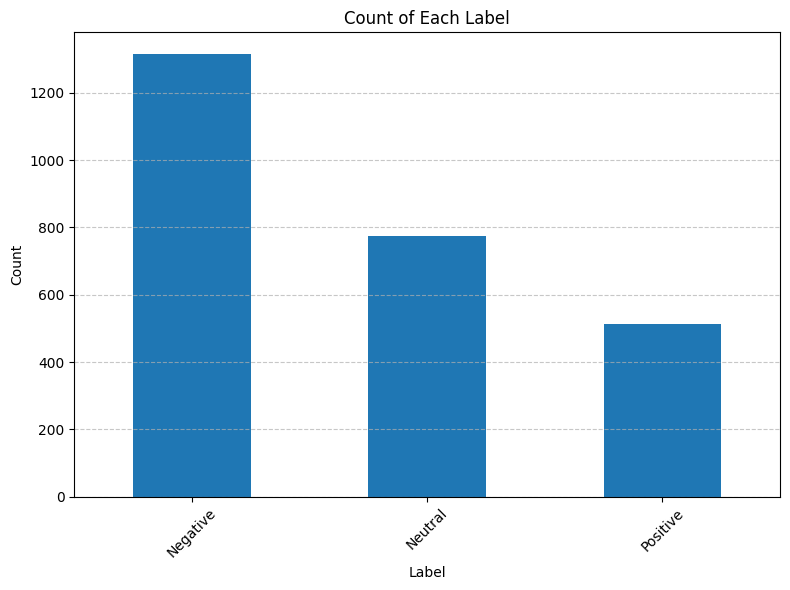

In [ ]:
visualize_label_counts(classificator_train,'label') # Visualizing the label counts in the 'classificator_train' DataFrame

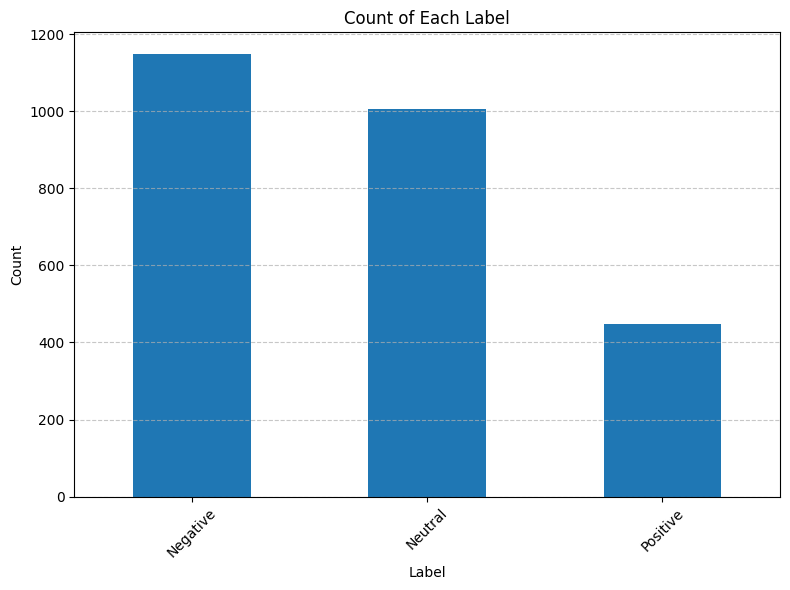

In [ ]:
visualize_label_counts(classificator_test,'label') # Visualizing the label counts in the 'classificator_test' DataFrame

After observing the imbalance in the number of instances for each label, we decided to merge 'Positive' and 'Neutral' labels into 'Other' to balance the test data for binary classification

In [ ]:
# Replacing 'Positive' and 'Neutral' labels with 'Other' in the 'label' column of the 'classificator_test' DataFrame
classificator_test['label'] = classificator_test['label'].replace(['Positive', 'Neutral'], 'Other')
# Replacing 'Positive' and 'Neutral' labels with 'Other' in the 'label' column of the 'classificator_train' DataFrame
classificator_train['label'] = classificator_train['label'].replace(['Positive', 'Neutral'], 'Other')

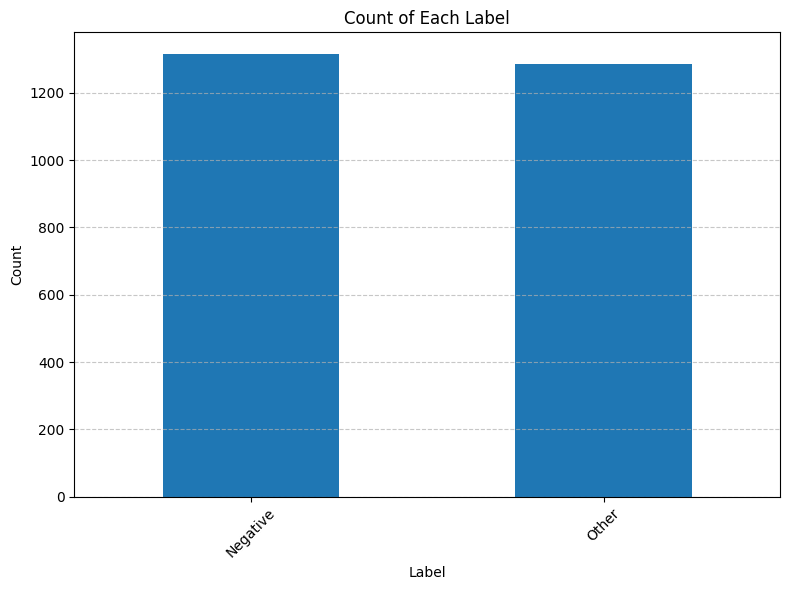

In [ ]:
visualize_label_counts(classificator_train,'label') # Visualizing the label counts in the 'classificator_train' DataFrame

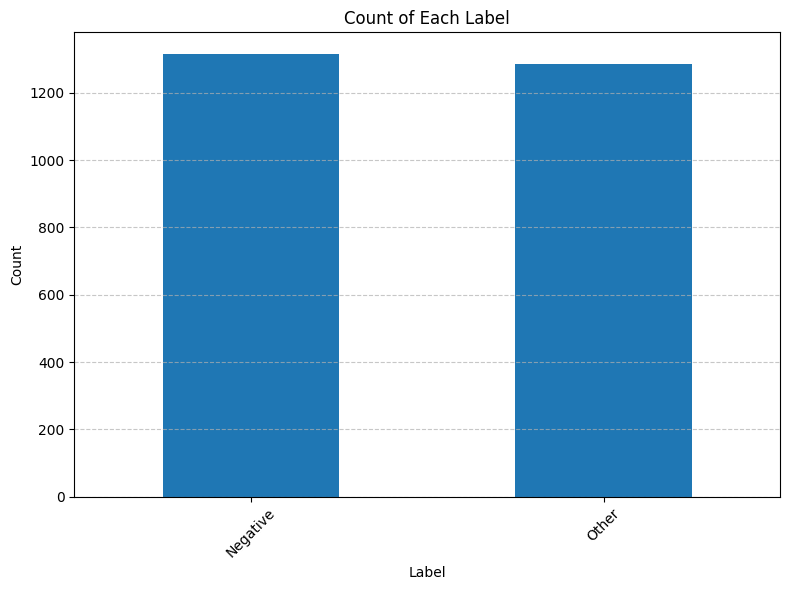

In [ ]:
visualize_label_counts(classificator_train,'label') # Visualizing the label counts in the 'classificator_test' DataFrame

In [ ]:
# Saving the modified 'classificator_test' DataFrame to a CSV file specified by 'args.classificator_test' without including the index
classificator_test.to_csv(args.classificator_test, index=False)
# Saving the modified 'classificator_train' DataFrame to a CSV file specified by 'args.classificator_train' without including the index
classificator_train.to_csv(args.classificator_train, index=False)

### Sentences


Sentences that will be used for testing the model are processed almost the same way as those for training the model. Some cleaning steps are removed from this part because this dataset is much cleaner.

In [ ]:
sentences = merged_df['sentence'].tolist() # create an array from the 'sentence' column in the dataframe

In [ ]:
n = 10
print(f"Show first {n} sentences:")
sentences[:n]

Show first 10 sentences:


['Da li je pošteno da se ukida prethodna stopa i da se povećava u odnosu na prethodnu?',
 'Znam pouzdano da su među specijalnim snagama bili pojedinci koji su učestvovali u organizovanom ubistvu predsednika Vlade ove države i da je tamo bilo dosta ubijenih civila u to vreme.',
 'Vizija predstavlja sliku idealne budućnosti a ciljevi način kako se ostvaruje ta vizija.',
 'Znači banke imaju 9 i pol milijardi kuna slobodnih sredstava, HNB vodi ekstenzivnu monetarnu politiku.',
 'Oni mogu biti i oružana agresija, dakle napad druge države, ali ono mogu biti i unutarnja oružana pobuna, oni mogu biti terorističke djelatnosti, može biti špijunaža, može biti diverzija.',
 'Da bi stečajna masa podigla svoj potencijal, jer ne samo da ću se naplatiti ja, nego i ostali poverioci zajedno sa mnom kojima se takođe duguje.',
 'Zemlje koje su uspješne nisu uspješne zbog interventnih mjera, nego zbog dalekovidne i pametne, pa ako hoćete i drske politike prije sedam, osam ili deset godina.',
 'Svatko ima p

In [ ]:
# all to lowercase, remove punctuation, only letters, remove words that are longer than 5 characters and all characters are consonants
cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

Show first 10 cleaned sentences:


['da li je pošteno da se ukida prethodna stopa i da se povećava u odnosu na prethodnu',
 'znam pouzdano da su među specijalnim snagama bili pojedinci koji su učestvovali u organizovanom ubistvu predsednika vlade ove države i da je tamo bilo dosta ubijenih civila u to vreme',
 'vizija predstavlja sliku idealne budućnosti a ciljevi način kako se ostvaruje ta vizija',
 'znači banke imaju i pol milijardi kuna slobodnih sredstava hnb vodi ekstenzivnu monetarnu politiku',
 'oni mogu biti i oružana agresija dakle napad druge države ali ono mogu biti i unutarnja oružana pobuna oni mogu biti terorističke djelatnosti može biti špijunaža može biti diverzija',
 'da bi stečajna masa podigla svoj potencijal jer ne samo da ću se naplatiti ja nego i ostali poverioci zajedno sa mnom kojima se takođe duguje',
 'zemlje koje su uspješne nisu uspješne zbog interventnih mjera nego zbog dalekovidne i pametne pa ako hoćete i drske politike prije sedam osam ili deset godina',
 'svatko ima pravo na pristup sudu

In [ ]:
# remove words with more than 30 letters, words with 2 consonant characters and words of only one consonant character (excluding k)
cleaned_sentences = filter_words(cleaned_sentences)
print(f"Show first {n} cleaned sentences:")
cleaned_sentences[:10]

Show first 10 cleaned sentences:


['da li je pošteno da se ukida prethodna stopa i da se povećava u odnosu na prethodnu',
 'znam pouzdano da su među specijalnim snagama bili pojedinci koji su učestvovali u organizovanom ubistvu predsednika vlade ove države i da je tamo bilo dosta ubijenih civila u to vreme',
 'vizija predstavlja sliku idealne budućnosti a ciljevi način kako se ostvaruje ta vizija',
 'znači banke imaju i pol milijardi kuna slobodnih sredstava hnb vodi ekstenzivnu monetarnu politiku',
 'oni mogu biti i oružana agresija dakle napad druge države ali ono mogu biti i unutarnja oružana pobuna oni mogu biti terorističke djelatnosti može biti špijunaža može biti diverzija',
 'da bi stečajna masa podigla svoj potencijal jer ne samo da ću se naplatiti ja nego i ostali poverioci zajedno sa mnom kojima se takođe duguje',
 'zemlje koje su uspješne nisu uspješne zbog interventnih mjera nego zbog dalekovidne i pametne pa ako hoćete i drske politike prije sedam osam ili deset godina',
 'svatko ima pravo na pristup sudu

In [ ]:
# remove all sentences that has less than 2 words
cleaned_sentences = [sentence for sentence in cleaned_sentences if len(sentence.split()) >= 2]

In [ ]:
print(f'Number of sentences after cleaning is {len(cleaned_sentences)}')

Number of sentences after cleaning is 5200


In [ ]:
# save cleaned sentences to the .txt file
save_to_txt_file(cleaned_sentences, filename=args.cleaned_sentences_test, separator='\n')

Data has been saved to the file: cleaned_sentences_test.txt


### Tokens

In the previous dataset (training set), we examined the content in terms of tokens. We will perform a similar analysis for this dataset as well.

#### Tokenizing sentences

In [ ]:
sentences = [simple_preprocess_text(sentence) for sentence in sentences] # preprocess the sentences

In [ ]:
tokens = tokenize_sentences(sentences) # tokenize sentences

#### Exploring the tokens

In [ ]:
freq = Counter(tokens) # count the frequency of each token

In [ ]:
freq.most_common(20) # display the 20 most common words and their frequencies

[('i', 3988),
 ('da', 3529),
 ('je', 2968),
 ('u', 2638),
 ('se', 2111),
 ('na', 1331),
 ('to', 1249),
 ('za', 1152),
 ('ne', 1001),
 ('su', 850),
 ('o', 849),
 ('što', 784),
 ('koji', 708),
 ('a', 648),
 ('od', 596),
 ('sa', 486),
 ('će', 475),
 ('nije', 438),
 ('mi', 421),
 ('bi', 418)]

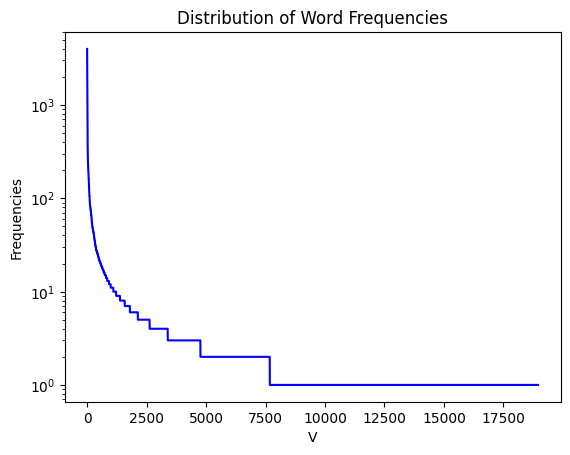

In [ ]:
plot_word_frequency_distribution(freq)

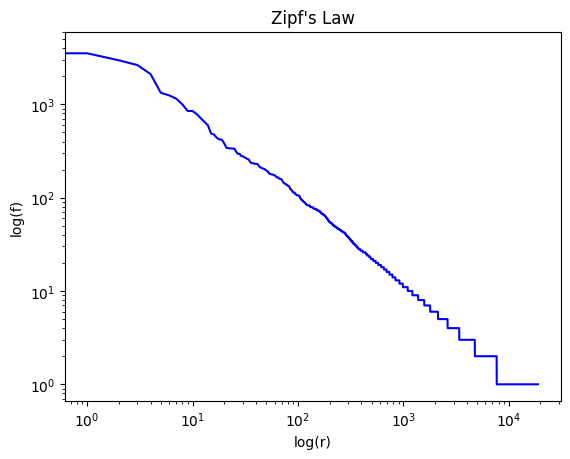

In [ ]:
plot_zipfs_law(freq)

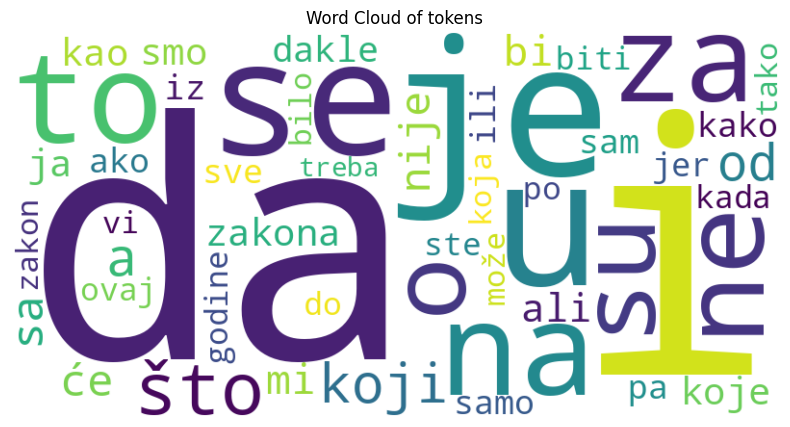

In [ ]:
# set the maximum number of words to be displayed in the WordCloud
max_words_to_display = 50 # adjust as needed
# title for the WordCloud
wordcloud_title = "Word Cloud of tokens"
# generate and display the WordCloud
generate_word_cloud(freq, max_words_to_display, wordcloud_title)

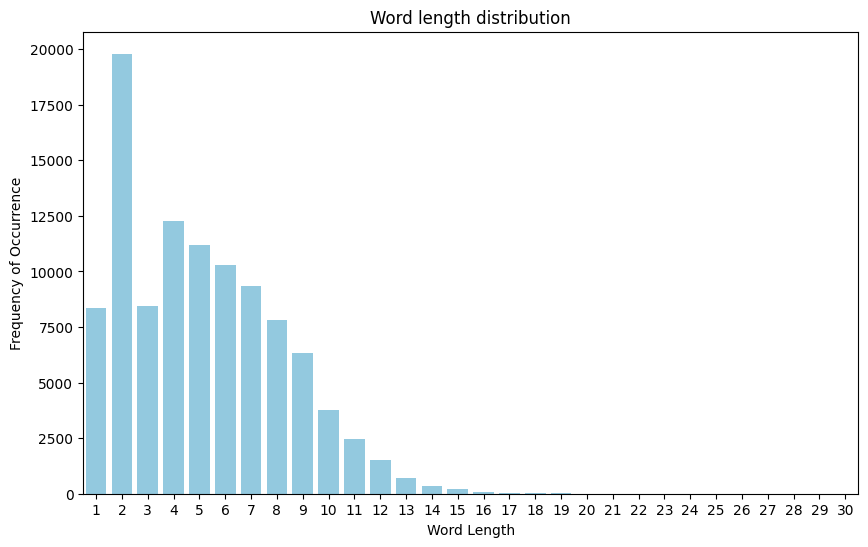

In [ ]:
# title for the histogram
histogram_title = "Word length distribution"
# generate and display the word length distribution histogram
plot_word_length_distribution(tokens, histogram_title)

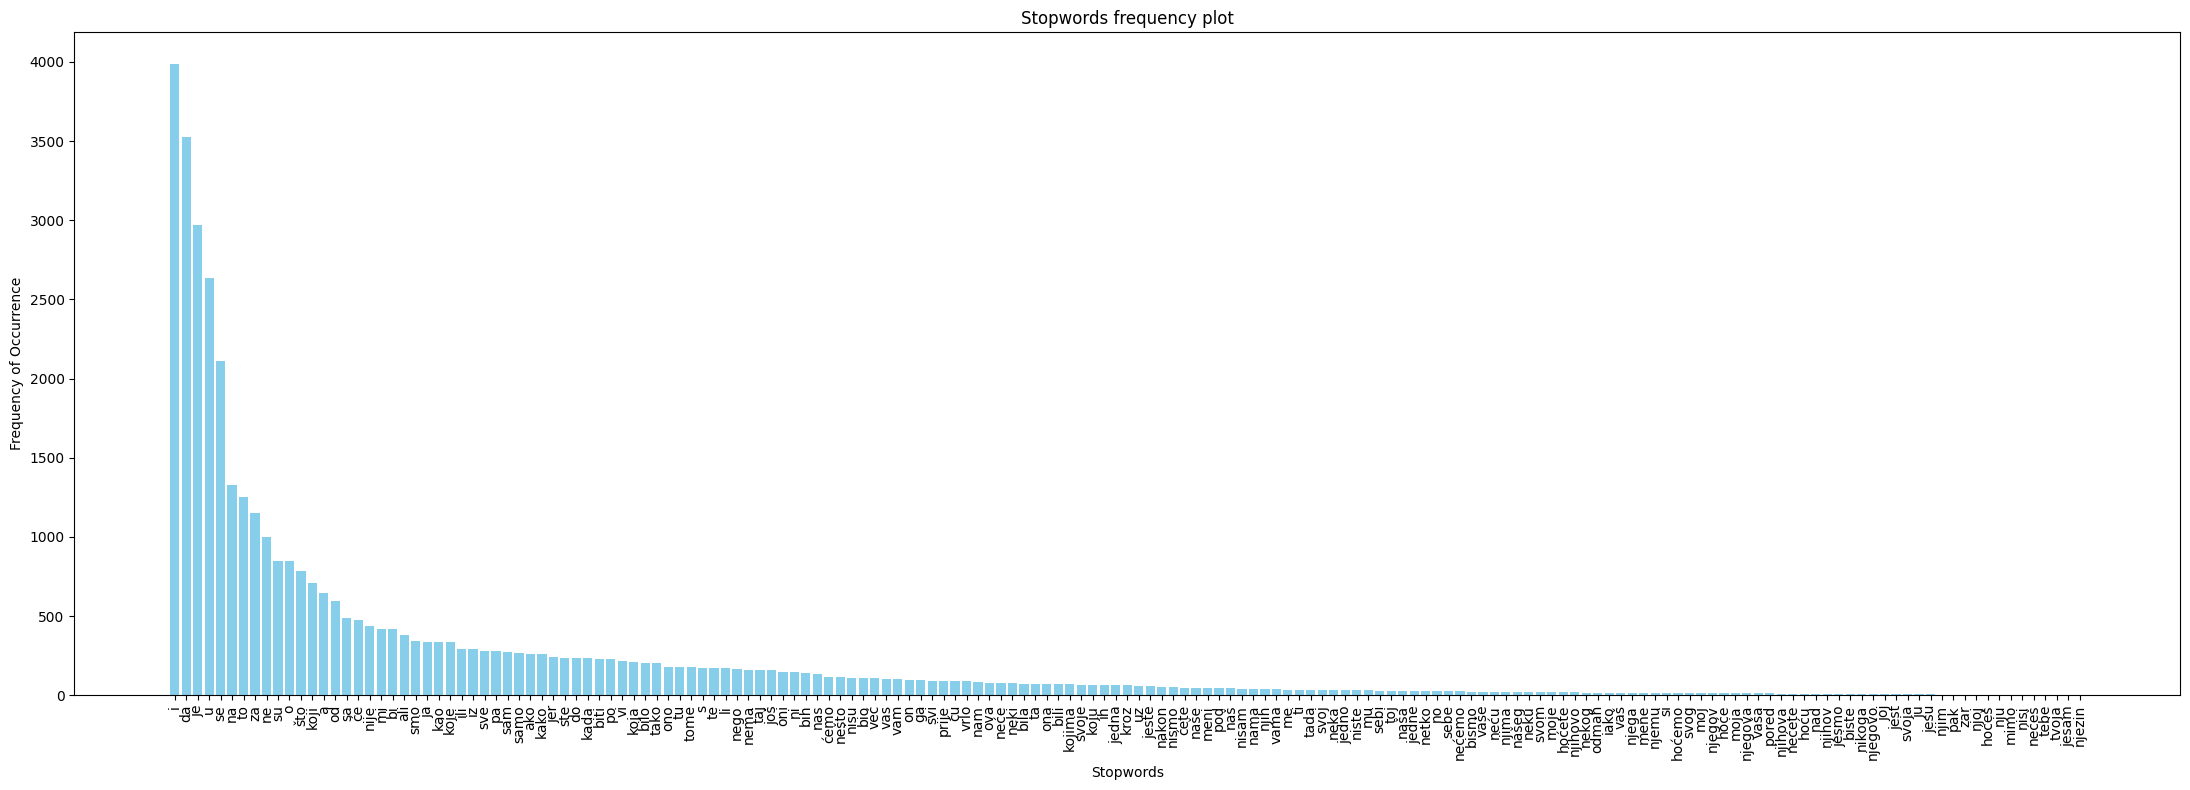

In [ ]:
# title for the chart
stopwords_plot_title = "Stopwords frequency plot"
# generate a chart for the frequency of stopwords
plot_stopwords_frequency(tokens, stopwords_hr, stopwords_plot_title)

##### Removing stopwords

In [ ]:
sentences = remove_stop_words(sentences, stopwords_hr)

In [ ]:
tokens = tokenize_sentences(sentences)

In [ ]:
freq_cleaned_wo_stopwords = Counter(tokens) # count the frequency of each word in the cleaned words list

In [ ]:
freq_cleaned_wo_stopwords.most_common(20) # display the 20 most common words and their frequencies

[('zakona', 337),
 ('dakle', 309),
 ('godine', 230),
 ('ovaj', 225),
 ('zakon', 209),
 ('može', 206),
 ('treba', 200),
 ('jedan', 197),
 ('ovo', 192),
 ('ima', 191),
 ('danas', 182),
 ('mislim', 179),
 ('sada', 177),
 ('onda', 175),
 ('zbog', 165),
 ('više', 165),
 ('toga', 161),
 ('prema', 159),
 ('znači', 152),
 ('način', 142)]

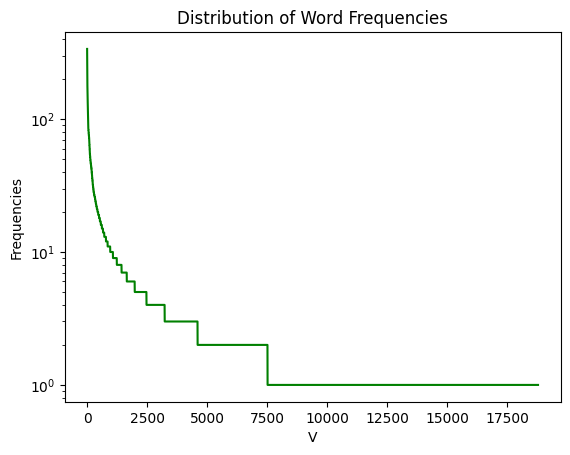

In [ ]:
plot_word_frequency_distribution(freq_cleaned_wo_stopwords, color='green')

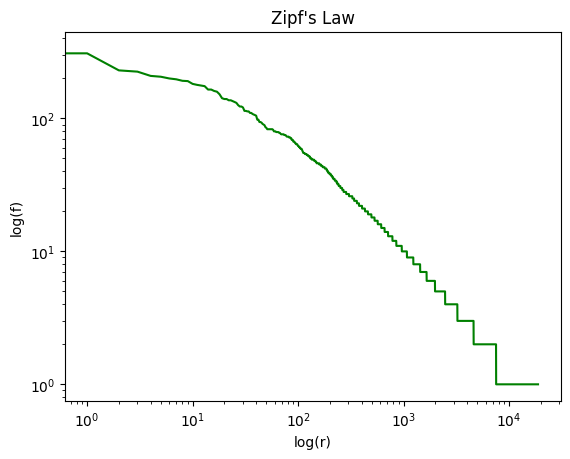

In [ ]:
plot_zipfs_law(freq_cleaned_wo_stopwords, color='green')

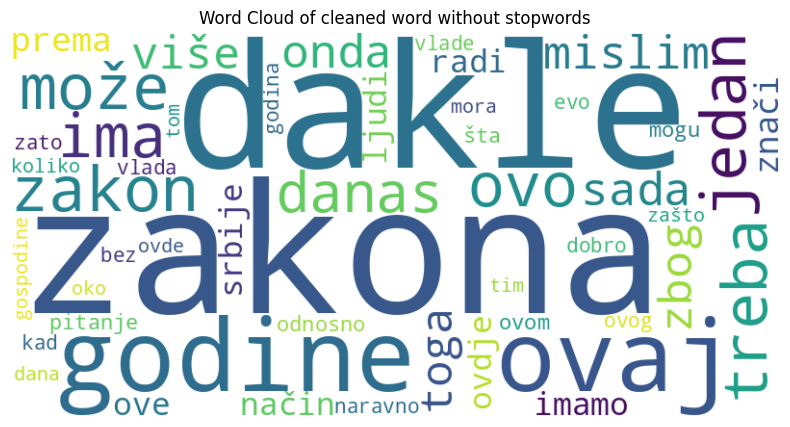

In [ ]:
# set the maximum number of words to be displayed in the WordCloud
max_words_to_display = 50 # adjust as needed
# title for the WordCloud
wordcloud_title = "Word Cloud of cleaned word without stopwords"
# generate and display the WordCloud
generate_word_cloud(freq_cleaned_wo_stopwords, max_words_to_display, wordcloud_title)

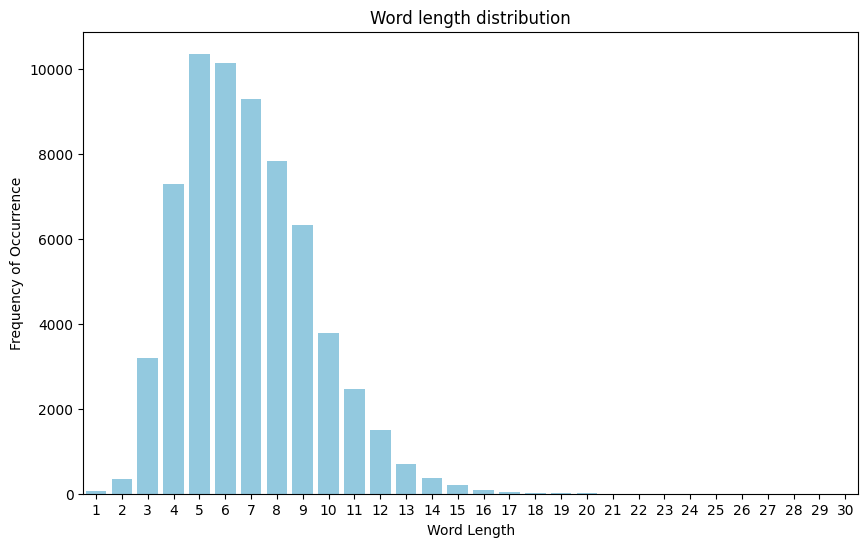

In [ ]:
# title for the histogram
histogram_title = "Word length distribution"
# generate and display the word length distribution histogram
plot_word_length_distribution(tokens, histogram_title)

#####       

Similar to the previous dataset, we observe analogous behavior in terms of the distribution of word frequencies, adherence to Zipf's law, the presence of common stop words (with the conjunction 'and' being the most frequent stop word once again), and word lengths. Regarding the most frequent words after removing stop words, 'law' emerges as the most common term, which aligns with the expected semantic focus of this dataset (ParlaSent).

### Data Preprocessing for Word Embedding Testing

#### GloVe (Global Vectors for Word Representation)

In [ ]:
%cd /content/drive/MyDrive/nlp_project/preprocessing_glove

/content/drive/MyDrive/nlp_project/preprocessing_glove


In [ ]:
vocabulary= load_serialized_object(args.glove_vocab) # load training vocabulary

In [ ]:
def build_co_occurrence_matrix(sentences, vocab, window_size=2):
  # initialize the co-occurrence matrix
  co_occurrence_matrix = defaultdict(dict)

  # iterate over each sentence in the collection
  for sentence in sentences:
    # tokenize the sentence
    tokens = sentence.split()
    # iterate over each token in the sentence

    for i, target_token in enumerate(tokens):
      # get the index of the target token from the vocabulary
      if target_token in vocab:
        target_idx = vocab[target_token]
      else:
        target_idx = 0  # set index to 0 for <UNK> token if target token not in vocabulary

      # define the context window for the current target token
      start = max(0, i - window_size)
      end = min(len(tokens), i + window_size + 1)
      context = tokens[start:i] + tokens[i + 1:end]  # Exclude the target token from the context

      # initialize the inner defaultdict for the target token if not already initialized
      if target_idx not in co_occurrence_matrix:
        co_occurrence_matrix[target_idx] = defaultdict(int)

      # iterate over each context token
      for context_token in context:
        # get the index of the context token from the vocabulary
        if context_token in vocab:
          context_idx = vocab[context_token]
        else:
          context_idx = 0  # set index to 0 for <UNK> token if context token not in vocabulary
        # update the co-occurrence count in the co-occurrence matrix
        co_occurrence_matrix[target_idx][context_idx] += 1

  return co_occurrence_matrix

In [ ]:
test_data = build_co_occurrence_matrix(cleaned_sentences, vocabulary) # create co-occurrence matrix and vocabulary for GloVe

In [ ]:
test_data

defaultdict(dict,
            {291838: defaultdict(int,
                         {364619: 146,
                          763066: 719,
                          410194: 1,
                          369193: 692,
                          155482: 3,
                          822167: 1,
                          341822: 377,
                          778209: 1,
                          123879: 15,
                          635797: 1,
                          88168: 113,
                          196805: 3,
                          748007: 3,
                          802177: 11,
                          551502: 148,
                          421393: 1,
                          647727: 220,
                          428528: 32,
                          373779: 12,
                          737129: 1,
                          833612: 1,
                          552260: 1,
                          47941: 3,
                          820558: 3,
                          221742: 5,
   

In [ ]:
unk_index = vocabulary['<UNK>']

# check if there are any occurrences of the UNK token in the co-occurrence matrix
unk_occurrences_at_index_0 = test_data[unk_index][0]
unk_occurrences_at_index_0

40

In [ ]:
# save data into files
save_serialized_object(test_data, filename= args.co_occurrence_matrix_test)

Data has been saved to the file: co_occurrence_matrix_test.pkl
